# Bert

## Imports

In [1]:
%pip install dotenv

%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
import os
import wandb
import time
from models.utils.evaluationUtility import analyze_all_results

2025-06-11 18:20:35.689749: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-11 18:20:35.689816: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-11 18:20:35.690869: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-11 18:20:35.698006: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-11 18:20:36.704333: W tensorflow/compiler/tf2

In [3]:
IS_PAPERSPACE = os.getcwd().startswith('/notebooks')
dir_env = os.path.join(os.getcwd(), '.env') if IS_PAPERSPACE else os.path.join(os.getcwd(), '..', '.env')
_ = load_dotenv(dotenv_path=dir_env)

In [4]:
wandb.login(key=os.getenv('WANDB_KEY'))
wandb._disable_jupyter = True

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Data

In [5]:
df_traindata = pd.read_csv("data/train.csv") if IS_PAPERSPACE else pd.read_csv("../data/train.csv")

train_texts, validation_texts, train_labels, validation_labels = train_test_split(
    df_traindata['text'].tolist(), 
    df_traindata['sentiment'].tolist(), 
    test_size=0.2, 
    random_state=42
)

df_testdata = pd.read_csv("data/test.csv") if IS_PAPERSPACE else pd.read_csv("../data/test.csv")
test_texts = df_testdata['text'].tolist()
test_labels = df_testdata['sentiment'].tolist()

## Vectorization

In [6]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
validation_encodings = tokenizer(validation_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) 
            for key, val in self.encodings.items()
        } | {
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
validation_dataset = TweetDataset(validation_encodings, validation_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

## Model

In [8]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from models.utils.evaluationUtility import calculate_metrics


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

try:
    os.environ["WANDB_API_KEY"] = "c9f6fc4517a3f6a4963c34996ef0fc78197c027d" # os.getenv('WANDB_KEY')
    wandb.login(key=os.getenv('WANDB_API_KEY'))

    os.environ["WANDB_PROJECT"] = "nlp-lantsch-schmassmann-wigger"
    os.environ["WANDB_ENTITY"] = "nlp-lantsch-schmassmann-wigger"
    os.environ["WANDB_WATCH"] = "all"
    
    wandb.init(
        project=os.getenv('WANDB_PROJECT'),
        entity=os.getenv('WANDB_ENTITY'),
        config={
            "learning_rate": 2e-5,
            "epochs": 3,
            "batch_size": 16
        }
    )

    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        save_total_limit=1,
        report_to=["wandb"] 
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=validation_dataset,
        compute_metrics=compute_metrics
    )

    start_time = time.time()
    trainer.train()
    end_time = time.time()
    training_duration = end_time - start_time
    trainer.evaluate()

    calculate_metrics(trainer, validation_dataset, validation_labels, test_dataset, test_labels, "bert-base-uncased", "bert-base-uncased", "bert", training_duration)


    wandb.finish()
except Exception as e:
    wandb.finish()
    raise e

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.405600,0.404074,0.833570,0.901005,0.865977
2,0.296600,0.391819,0.874280,0.857204,0.865658
3,0.193900,0.530596,0.866989,0.867113,0.867051


Inference time for 44999 texts: 57.7272 seconds

Classifier: bert-base-uncased | Vectorizer: bert-base-uncased
Validation Accuracy: 0.8457
Test Accuracy: 0.8414
Training Duration: 2873.08 seconds


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/f1,▃▁██
eval/loss,▂▁██
eval/precision,▁█▇▇
eval/recall,█▁▃▃
eval/runtime,▄▁█▂
eval/samples_per_second,▅█▁▇
eval/steps_per_second,▅█▁▇
train/epoch,▁▁▅▅████
train/global_step,▁▁▅▅█████
train/learning_rate,█▅▁
train/loss,█▄▁


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When groupi

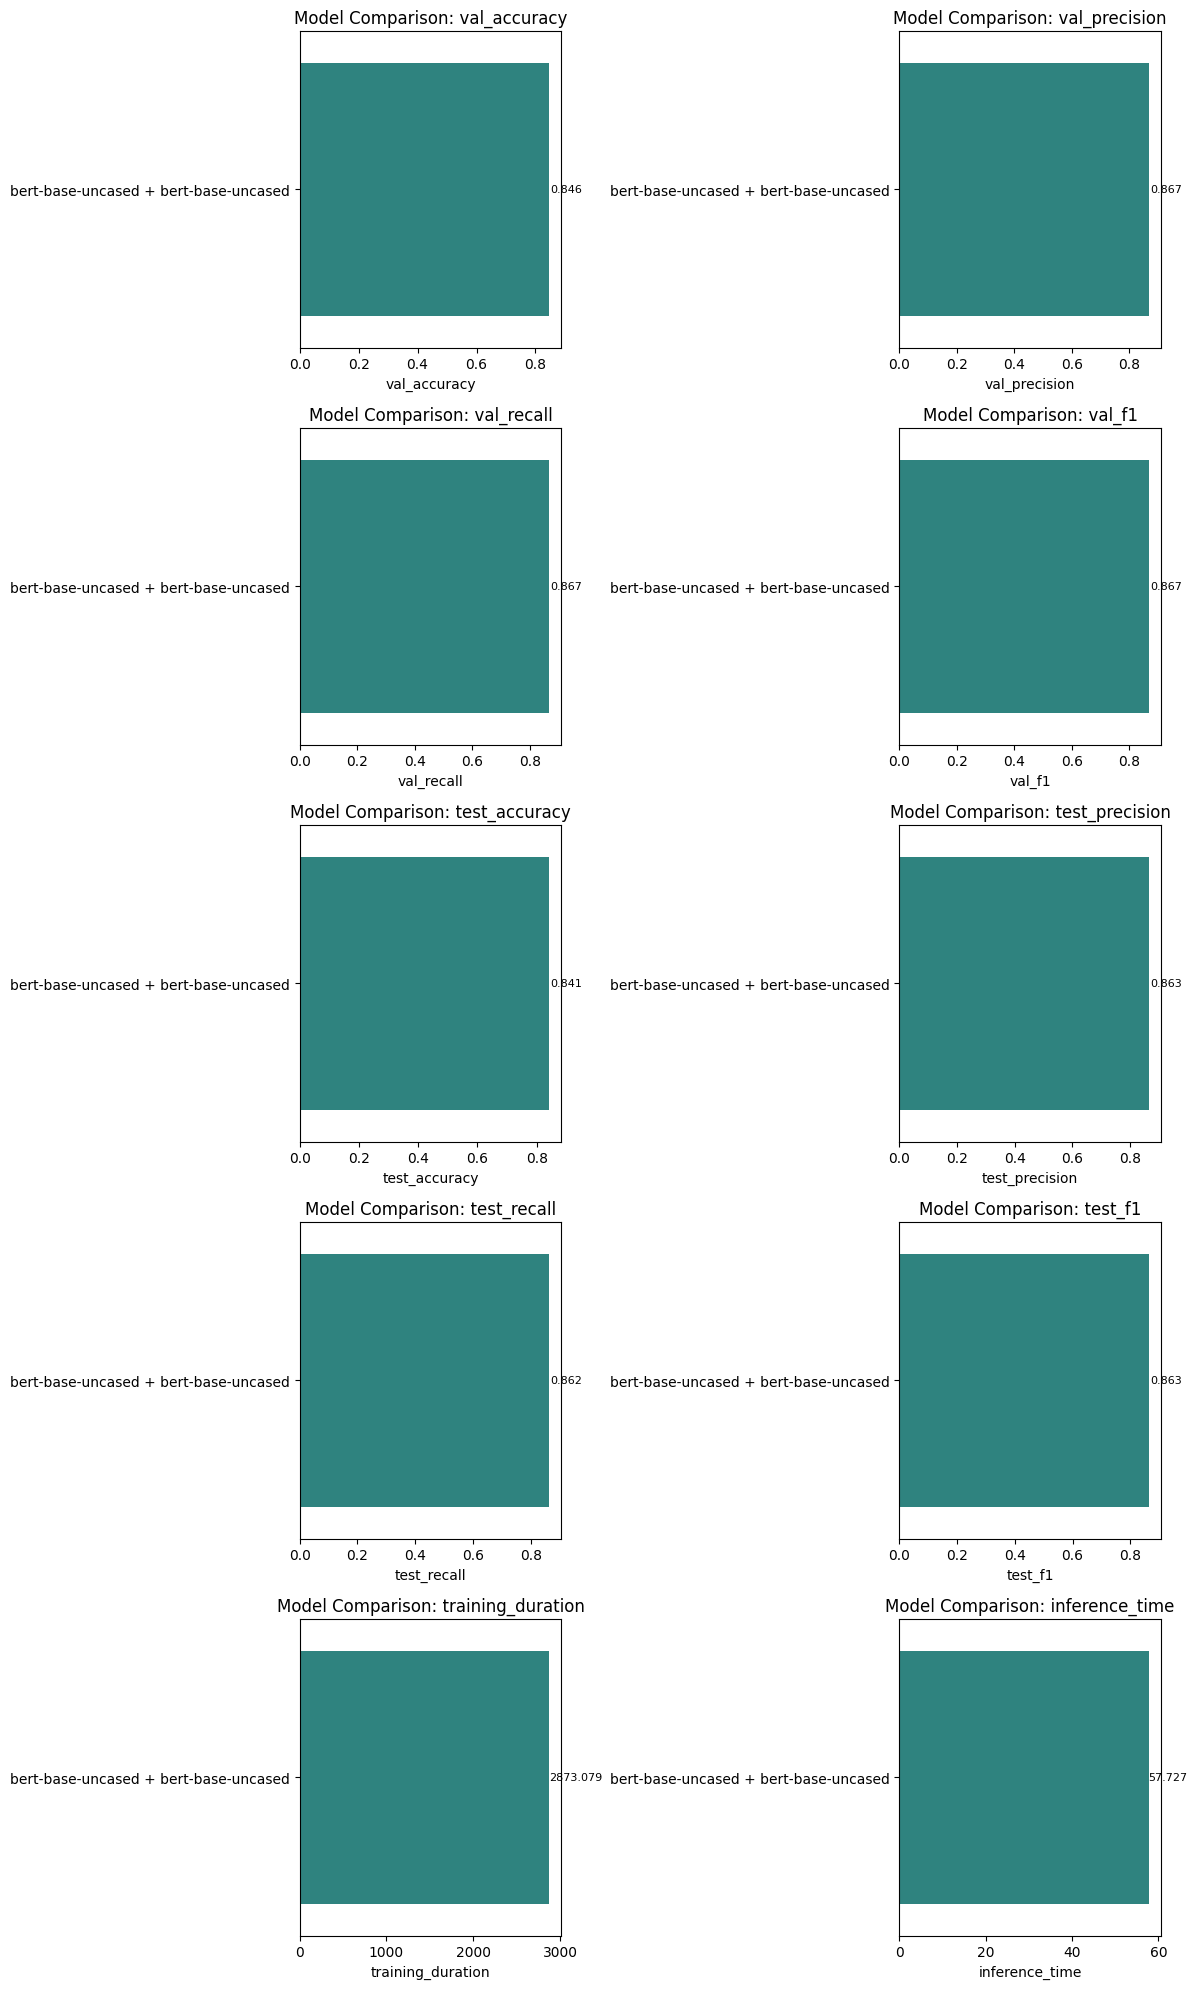

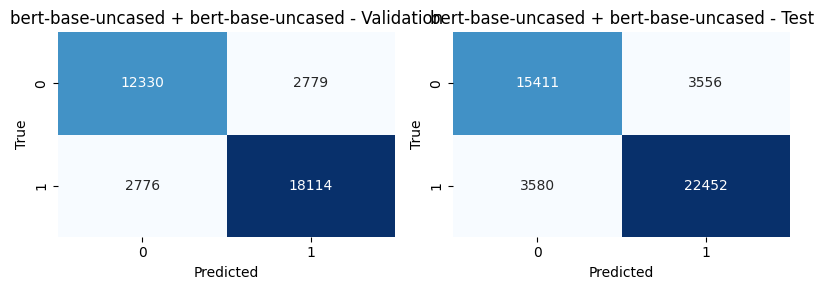

,classifier,vectorizer,val_accuracy,val_precision,val_recall,val_f1,test_accuracy,test_precision,test_recall,test_f1,training_duration,inference_time,Classifier,Vectorizer,Validation Confusion,Test Confusion,Model
0,bert-base-uncased,bert-base-uncased,0.84569,0.866989,0.867113,0.867051,0.841419,0.863273,0.862477,0.862875,2873.079232,57.727222,bert-base-uncased,bert-base-uncased,"[[12330, 2779], [2776, 18114]]","[[15411, 3556], [3580, 22452]]",bert-base-uncased + bert-base-uncased


In [13]:
analyze_all_results(results_dir="executions/bert")